## Instalações Necessárias

In [109]:
%pip install -qU pypdf
%pip install -U langchain
%pip install -U langchain-community
%pip install -U langchain-groq
%pip install langchain-huggingface
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Importações necessárias

In [110]:
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
from IPython.display import display, Markdown
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from IPython.display import display, Markdown
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from typing import List
from langchain.schema import Document

## Modelo de LLM

In [111]:
llm = ChatOllama(model="mistral")

## Modelo de embedding

In [170]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embed_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Stor

## Métodos para suporte

In [171]:
def carrega_pdf(url:str)->str:
    loader = PyPDFLoader(url)
    pages = []
    for page in loader.lazy_load():
        pages.append(page)
        # print(f"{page.metadata}\n")
    vectorstore = InMemoryVectorStore.from_documents(pages,embed_model)
    return vectorstore

## Criando vetores com os embeddings

In [172]:
vector_store_nasa = carrega_pdf("NASA.pdf")

In [173]:
vector_store_dengue = carrega_pdf("dengue.pdf")

In [174]:
vector_store_agriculture = carrega_pdf("agriculture.pdf")

## Ferramentas

In [188]:
@tool
def pega_contexto_nasa(query: str) -> str:
    """Pega o contexto baseado em uma pesquisa sobre a NASA."""
    retriever = vector_store_nasa.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [189]:
@tool
def pega_contexto_agriculture(query: str) -> str:
    """Pega o contexto sobre agricultura baseado em uma pesquisa."""
    retriever = vector_store_agriculture.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [190]:
@tool
def pega_contexto_dengue(query: str) -> str:
    """Pega o contexto sobre dengue baseado em uma pesquisa."""
    retriever = vector_store_dengue.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [192]:
tools = [pega_contexto_nasa,pega_contexto_agriculture,pega_contexto_dengue]

## Criando agente

In [193]:
system_prompt = """
You are an assistant specialized in retrieving knowledge from documents.
Rules:
- If the user asks about NASA, you MUST call ONLY pega_contexto_nasa.
- If the user asks about agriculture, you MUST call ONLY pega_contexto_agriculture.
- If the user asks about dengue, you MUST call ONLY pega_contexto_dengue.
- NEVER answer directly with your own words.
- NEVER suggest how to use the tool.
- ALWAYS call the correct tool and return its result as the final answer.
- If no relevant info is found by the tool, then say 'I don't know'.
"""


In [194]:
agente_pdf = create_react_agent(model = llm, tools = tools,prompt= system_prompt,)

## Pergunta para o Agente

In [195]:
pergunta = "What are the Objectives Development Process in NASA?"
resposta = agente_pdf.invoke({"messages": [("user", pergunta)]})
print(resposta["messages"][-1].content)


 The Objectives Development Process in NASA involves the following steps:
1. In November 2021, the NASA Executive Council tasked the mission directorates to draft a set of top-level goals and objectives necessary to achieve the Moon to Mars endeavor.
2. The top-level goals and objectives were binned into four distinct tracks: Science, Infrastructure, Transportation and Habitation, and Operations. Each of the mission directorate leaders on the Federated Board led the development of corresponding objectives.
3. The Aeronautics Mission Directorate supported the Science Mission Directorate with the Science objectives and was actively involved in the entire objectives development process.
4. The Federated Board reached consensus on an initial draft set of 45 objectives by March 2022.
5. A gap analysis was conducted to assess the draft objectives against current and planned Moon to Mars activities, which resulted in the addition of five new objectives, one new overarching principle, six edit

In [197]:
pergunta = "What causes dengue"
resposta = agente_pdf.invoke({"messages": [("user", pergunta)]})
print(resposta["messages"][-1].content)

 Dengue is caused by viruses that belong to the Flaviviridae family, specifically in the genus Flavivirus. The disease is primarily transmitted through the bite of infected Aedes mosquitoes (Aedes aegypti and Aedes albopictus). Infected individuals can also transmit the virus during the incubation period or shortly before symptoms appear, as well as after recovery for several weeks, increasing the risk of further transmission. The four serotypes of dengue virus (DEN-1, DEN-2, DEN-3, and DEN-4) cause a spectrum of clinical manifestations ranging from asymptomatic or mild inapparent infection to severe illness like dengue hemorrhagic fever and dengue shock syndrome.


In [198]:
pergunta = "Why agriculture is important to indian economy?"
resposta = agente_pdf.invoke({"messages": [("user", pergunta)]})
print(resposta["messages"][-1].content)

 This text appears to be the abstract and parts of a research paper about analyzing agricultural data using R and Microsoft Azure, specifically focusing on the production of various crops in Tamil Nadu, India. The authors aim to identify high, average, and low production crops based on their analysis. The data was obtained from Kaggle and other sources.

Key findings include:
- Mango, Maize, Coconut, Cotton(lint), Total foodgrain, Guar seed, Rice, Banana, Sugarcane were identified as high production crops.
- Grapes and Dry ginger were identified as low production crops.

The paper also includes figures such as a crop wise production analysis chart. Further details can be found in the complete research paper.


## Criando Grafos

In [200]:
grafo = StateGraph(MessagesState)
grafo.add_node("assistente",agente_pdf)
grafo.add_node("tools",ToolNode(tools))
grafo.add_edge(START,"assistente")
grafo.add_conditional_edges("assistente",tools_condition)
grafo.add_edge("tools","assistente")
grafo.add_edge("assistente",END)

## Adicionando memória

In [201]:
memoria = MemorySaver()
app = grafo.compile(checkpointer=memoria)

## Mostrando processo

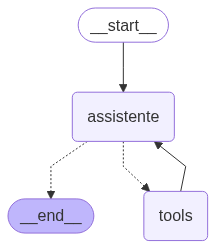

In [202]:
Image(app.get_graph().draw_mermaid_png())

## Chat com memória

In [203]:
def chat_com_memoria(mensagem_usuario: str, thread_id="1",verbose = True):
    config ={"configurable": {"thread_id": thread_id}}
    messages = app.invoke({"messages":[HumanMessage(content=mensagem_usuario)]},config)
    if verbose:
        for message in messages['messages']:
            message.pretty_print()
    else:
        messages['messages'][-1].pretty_print()

In [204]:
chat_com_memoria(
    mensagem_usuario="Why is agriculture crucial for India's economy, and what's its current need?", 
    thread_id="2", 
    verbose=False
    )

================================== Ai Message ==================================

 The documents contain excerpts from two academic papers related to the analysis of crop production data using R Tool.

The first document mentions the analysis of crop production dataset for Tamil Nadu, India, from 1997 to 2013. The dataset includes details like district name, crop year, season, crop, area, and production. In this paper, the focus is on analyzing the crop production data for Virudhunagar district specifically. The data shows that crops like Mango, Maize, Coconut, Cotton(lint), Rice, Banana, Sugarcane are high-production crops in the region. Meanwhile, crops like Grapes, Dry ginger, Gram, and Potato are low-production crops.

The second document presents an analysis of crop production data for a district where 65 different crops were produced across various seasons (Whole Year, Kharif, Rabi). The frequently sown crops include Ragi, Groundnut, Cotton(lint), Urad, Moong(Green Gram), Maize, 

In [205]:
chat_com_memoria(
    mensagem_usuario="What was the last question i send to you ?", 
    thread_id="2", 
    verbose=False
    )

================================== Ai Message ==================================

 The last question I sent to you was about agriculture. So, to provide you with the requested context, I will use the function pega_contexto_agriculture.


In [206]:
chat_com_memoria(
    mensagem_usuario="Which programing language was used on the research ?", 
    thread_id="2", 
    verbose=False
    )

================================== Ai Message ==================================

 The text you provided appears to be the contents of a scientific paper or research article about analyzing agricultural data using R and Microsoft Azure. It discusses the analysis of agriculture data from Tamil Nadu, India, focusing on various aspects such as crop production in different seasons, crop production over the years (from 1997 to 2013), and listing out low, average, and high production crops. The paper also mentions the challenges faced by farmers and stakeholders in managing agricultural data and the benefits of using technology for cost savings, reduction in fertilizer, yield optimization, etc.

The text also includes references to other research papers, websites, and datasets related to agriculture and big data analysis. It appears that this paper is published in the International Journal of Engineering and Advanced Technology (IJEAT).
